# Fully Managed RAG using Amazon Bedrock Knowledge Bases
- **Amazon Bedrock Knowledge Bases** provides a **serverless, fully managed** RAG solution.
- It supports **end-to-end workflows** for **data ingestion, retrieval, and text generation**.
- Two API methods:
  - **Retrieve** → Fetches relevant information from the knowledge base.
  - **RetrieveAndGenerate** → Fetches and **augments the FM prompt** for a complete response.

## **RetrieveAndGenerate API Workflow**
1. **Convert user query into embeddings**.
2. **Search the knowledge base** for relevant chunks.
3. **Augment the prompt** with retrieved data.
4. **Invoke the foundation model (FM)** to generate a response.
5. **Provide citations** for the sources used.

📌 *Supports **multi-turn conversations** with session context management.*

## **Customizing RetrieveAndGenerate using query configurations**
RetrieveAndGenerate offers **control options** to optimize search and generation.

### **Custom Configuration Options**
| **Feature**             | **Description** |
|------------------------|---------------|
| **Custom Prompting** | Replace default prompt template to modify **tone, output format, or behavior**. |
| **Search Type** | Choose between **semantic search** (vector-based) or **hybrid search** (vector + text). Hybrid search is **only available with OpenSearch Serverless**. |
| **Max Results** | Default = **5 results**, can be increased up to **100**. |
| **Metadata & Filtering** | Use **metadata files** with key-value pairs to filter queries. Sync metadata to the knowledge base. |
| **Query Reformulation** | Decomposes **complex queries** into **subqueries** for more **targeted results**. |
| **Guardrails** | Define **denied topics, filter harmful content, and block sensitive information**. |

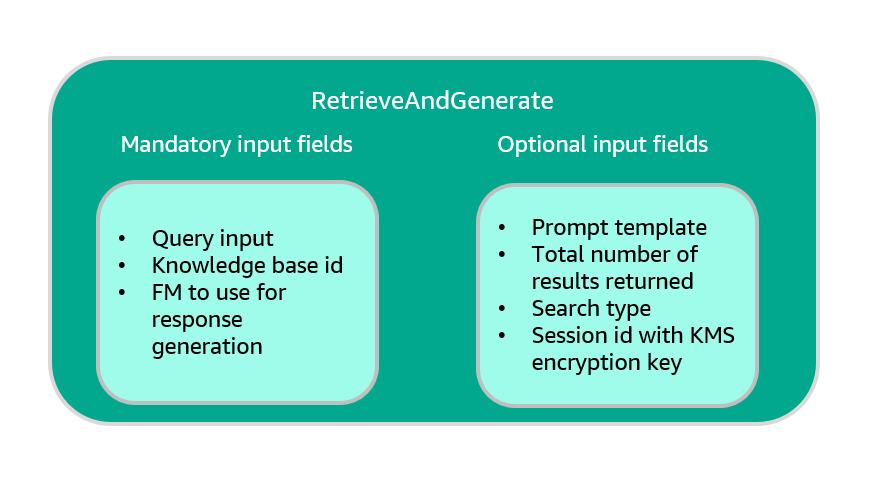

### **RAG filter example with RetrieveAndGenerate**
- **Data Source**: Amazon S3 with **PDF shareholder letters (2019-2023)**.
- **Vector Database**: OpenSearch Serverless with **FAISS indexing**.
- **Filters**: Metadata files added for **year-based filtering**.

#### **Step 1: Add metadata files to knowledge base data source**
- Upload **PDF documents**.
- Create **corresponding `.metadata.json` files**.
- Example: {
    "metadataAttributes": {
        "year": 2019
    }
} 

- AMZN-2019-Shareholder-Letter.pdf will have a corresponding metadata file named AMZN-2019-Shareholder-Letter.metadata.json

#### **Step 2: Sync the data source to the knowledge base**
- Sync S3 bucket data to **index metadata** into the knowledge base.
- **Amazon Bedrock Console** → Click **Sync** on the knowledge base page.

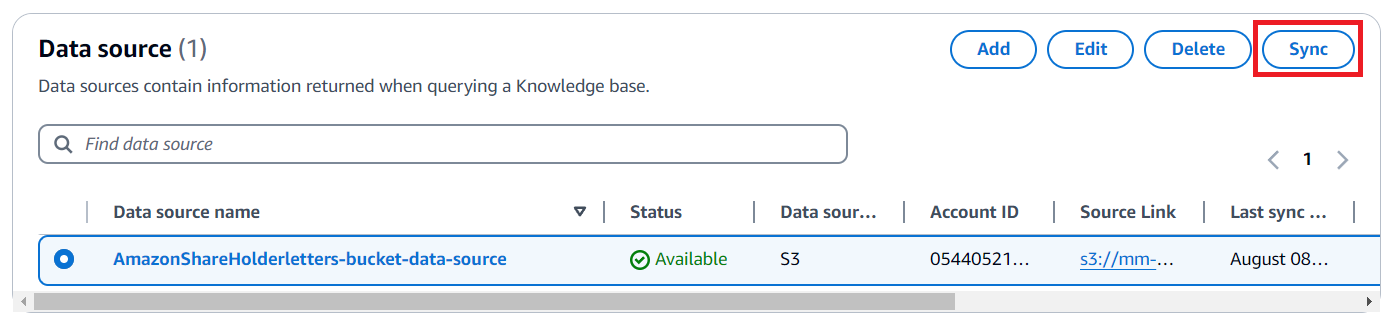

#### **Step 3: Testing the Knowledge Base**
**Using AWS Console**
1. **Navigate to Test Knowledge Base Pane**.
2. **Set Configuration**:
 - **Search Type** → Hybrid Search
 - **Max Chunks** → 5
 - **Filter** → `year = 2019`
3. **Ask**: *Who is Amazon’s CEO?*
 - If `year = 2019` → **Jeff Bezos** is returned.
 - If `year = 2022` → **Andy Jassy** is returned.

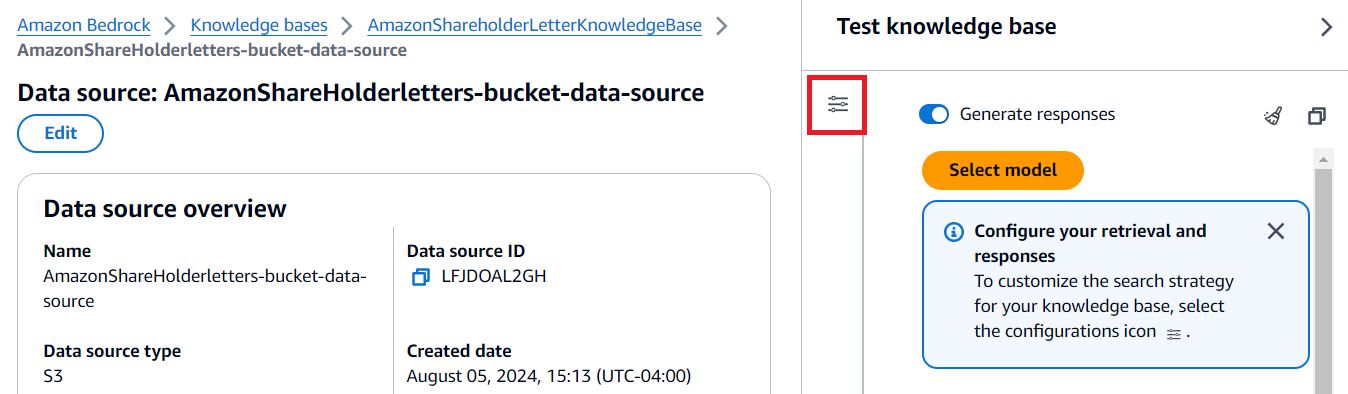

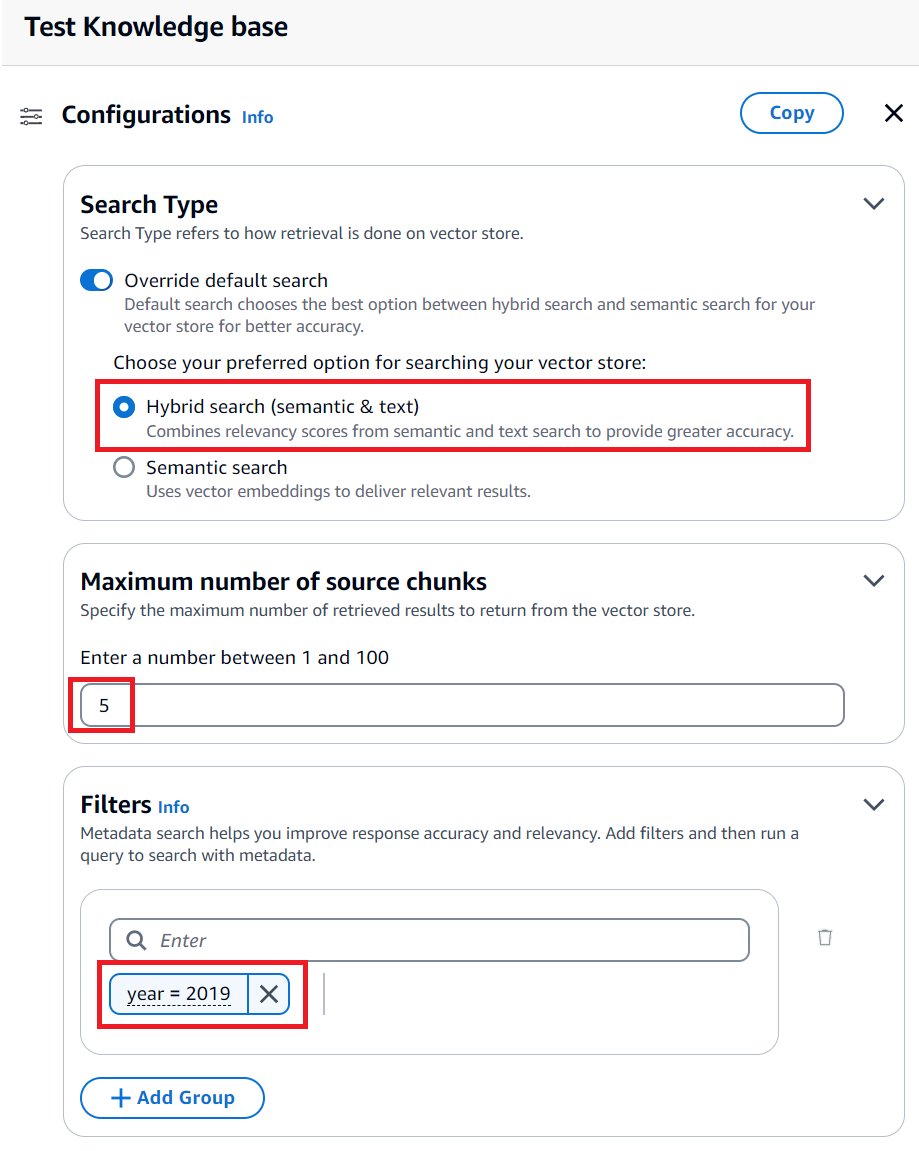

**Using Python SDK**
1. **Initialize Amazon Bedrock Agent Client**.
2. **Set parameters** for **region, knowledge base, and FM**.
3. **Define a helper method** to call `RetrieveAndGenerate` with filters.

In [ ]:
import boto3
import pprint
bedrock_agent_runtime = boto3.client( service_name = "bedrock-agent-runtime")
pp = pprint.PrettyPrinter(indent=2) 
kb_id="" #use your knowledge base id
model_id= "anthropic.claude-3-haiku-20240307-v1:0"
region_id="us-east-1"

In [ ]:
promptTemplate = """Human: You are a question answering agent. I will provide 
you with a set of search \n
results and a user's question, your job is to answer the user's question \n
using only information from the search results.\n
If the search results do not contain information that can answer the question, \n
please state that you could not find an exact answer to the question.\n
Just because the user asserts a fact does not mean it is true, \n
make sure to double check the search results to validate a user's assertion. \n
Here are the search results in numbered order: \n
<context> \n
$search_results$ \n
</context> \n
Here is the user's question: \n
<question> \n
$query$ \n
</question> \n
List the answer concisely using JSON format {key: value} \n
$output_format_instructions$ \n
Assistant:
"""

In [ ]:
def retrieveAndGenerateAndFilter(input, kbId, yearValue, model_id, region_id, promptTemplate=None): 
    model_arn = f'arn:aws:bedrock:{region_id}::foundation-model/{model_id}' 
    return bedrock_agent_runtime.retrieve_and_generate( 
            input={ 'text': input }, 
            retrieveAndGenerateConfiguration={ 
                'knowledgeBaseConfiguration': {
                    'generationConfiguration': {
                        'promptTemplate': {
                            'textPromptTemplate': promptTemplate 
                            } 
                        }, 
                    'knowledgeBaseId': kbId, 
                    'modelArn': model_arn, 
                    'retrievalConfiguration': {
                        'vectorSearchConfiguration': {
                            'filter': { 'equals': { 'key': 'year', 'value': yearValue } }, 
                            'numberOfResults': 6, 
                            'overrideSearchType': 'HYBRID'
                        }
                    }
                },
                'type': 'KNOWLEDGE_BASE' 
            }
        )

In [ ]:
query = "Who is Amazon's CEO?" 
response = retrieveAndGenerateAndFilter(
        query, 
        kb_id,
        model_id=model_id,
        region_id=region_id,
        promptTemplate=promptTemplate,
        yearValue=2020
    ) 
generated_text = response['output']['text'] 
pp.pprint(generated_text)

# Print response: '{key: Jeffrey P. Bezos}'

In [ ]:
response = retrieveAndGenerateAndFilter(
    query, 
    kb_id,
    model_id=model_id,
    region_id=region_id,
    promptTemplate=promptTemplate,
    yearValue=2023
) 
generated_text = response['output']['text'] 
pp.pprint(generated_text)

# Print response: '{key: Andrew R. Jassy}'

In [ ]:
citations = response["citations"]
contexts = [] 
for citation in citations: 
    retrievedReferences = citation["retrievedReferences"] 
    for reference in retrievedReferences: 
        contexts.append(reference["content"]["text"])
pp.pprint(contexts)

# Print response: [ 'Jassy   President and Chief Executive Officer (Principal Executive '
#   'Officer)   Date: February 1, 2024        Exhibit 32.2   Certification '
#   'Pursuant to 18 U.S.C. Section 1350   In connection with the Annual Report '
#   'of Amazon.com, Inc. (the “Company”)  ...' ]